# DCGAN: Generate the images with Deep Convolutional GAN
Note: This notebook is created from [chainer/examples/dcgan](https://github.com/chainer/chainer/tree/master/examples/dcgan). If you want to run it as script, please refer to the above link.

In this notebook, we generate images with **generative adversarial network (GAN)**.

![Generated Image](https://cdn-images-1.medium.com/max/1600/0*yeBUm7SfMaHjnFd2.gif)

First, we execute the following cell and install "Chainer" and its GPU back end "CuPy". If the "runtime type" of Colaboratory is GPU, you can run Chainer with GPU as a backend.

In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   9294      0 --:--:-- --:--:-- --:--:--  9294
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 339.6MB 51kB/s 
+ set +ex
Installation succeeded!


Let's import the necessary modules, then check the version of Chainer, NumPy, CuPy, Cuda and other execution environments.

In [ ]:
import os

import numpy as np

import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import Variable
from chainer.training import extensions


chainer.print_runtime_info()

Platform: Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 6.5.0
ChainerX: Not Available
NumPy: 1.18.5
CuPy:
  CuPy Version          : 7.6.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10000
  cuBLAS Version        : 10000
  cuFFT Version         : 10000
  cuRAND Version        : 10000
  cuSOLVER Version      : (10, 0, 0)
  cuSPARSE Version      : 10000
  NVRTC Version         : (10, 0)
  cuDNN Build Version   : 7605
  cuDNN Version         : 7605
  NCCL Build Version    : 2506
  NCCL Runtime Version  : 2506
  CUB Version           : None
  cuTENSOR Version      : None
iDeep: 2.0.0.post3


## 1. Setting parameters
Here we set the parameters for training.

* `` n_epoch``: Epoch number. How many times we pass through the whole training data.
* `` n_units``: Number of units. How many hidden state vectors each Recursive Neural Network node has.
* `` batchsize``: Batch size. How many train data we will input as a block when updating parameters.
* `` n_label``: Number of labels. Number of classes to be identified. Since there are 5 labels this time, `` 5``.
* `` epoch_per_eval``: How often to perform validation.
* `` is_test``: If `` True``, we use a small dataset.
* `` gpu_id``: GPU ID. The ID of the GPU to use. For Colaboratory it is good to use `` 0``.

In [ ]:
# parameters
n_epoch = 3  # number of epochs, ideally >50, but we can write down only 1 to test the notebook
n_hidden = 100  # number of hidden units
batchsize = 50  # minibatch size
snapshot_interval = 10000  # number of iterations per snapshots
display_interval = 100  # number of iterations per display the status
gpu_id = 0
out_dir = 'result'
seed = 0  # random seed

## 2. Preparation of training data and iterator
In this notebook, we will use the training data which are preprocessed by [chainer.datasets.get_cifar10](https://docs.chainer.org/en/stable/reference/generated/chainer.datasets.get_cifar10.html#chainer.datasets.get_cifar10). 

From [Wikipedia](https://en.wikipedia.org/wiki/CIFAR-10), it says

> The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research.The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

Let’s retrieve the CIFAR-10 dataset by using Chainer’s dataset utility function `get_cifar10`. CIFAR-10 is a set of small natural images. Each example is an RGB color image of size 32x32. In the original images, each component of pixels is represented by one-byte unsigned integer. This function scales the components to floating point values in the interval `[0, scale]`.

In [ ]:
# Load the CIFAR10 dataset if args.dataset is not specified
train, _ = chainer.datasets.get_cifar10(withlabel=False, scale=255.)

In [ ]:
train_iter = chainer.iterators.SerialIterator(train, batchsize)


## 3. Preparation of the model

Let's define the network.
We will create the model called DCGAN(Deep Convolutional GAN).
As shown below, it is a model using CNN(Convolutional Neural Network) as its name suggests.

![DCGAN](https://cdn-images-1.medium.com/max/800/1*KvMnRfb76DponICrHIbSdg.png) cited from [1]


First, let’s define a network for the generator.

In [ ]:
class Generator(chainer.Chain):

    def __init__(self, n_hidden, bottom_width=4, ch=512, wscale=0.02):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            w = chainer.initializers.Normal(wscale)
            self.l0 = L.Linear(self.n_hidden, bottom_width * bottom_width * ch,
                               initialW=w)
            self.dc1 = L.Deconvolution2D(ch, ch // 2, 4, 2, 1, initialW=w)
            self.dc2 = L.Deconvolution2D(ch // 2, ch // 4, 4, 2, 1, initialW=w)
            self.dc3 = L.Deconvolution2D(ch // 4, ch // 8, 4, 2, 1, initialW=w)
            self.dc4 = L.Deconvolution2D(ch // 8, 3, 3, 1, 1, initialW=w)
            self.bn0 = L.BatchNormalization(bottom_width * bottom_width * ch)
            self.bn1 = L.BatchNormalization(ch // 2)
            self.bn2 = L.BatchNormalization(ch // 4)
            self.bn3 = L.BatchNormalization(ch // 8)

    def make_hidden(self, batchsize):
        return np.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(np.float32)

    def __call__(self, z):
        h = F.reshape(F.relu(self.bn0(self.l0(z))),
                                (len(z), self.ch, self.bottom_width, self.bottom_width)) 
        h = F.relu(self.bn1(self.dc1(h)))
        h = F.relu(self.bn2(self.dc2(h)))
        h = F.relu(self.bn3(self.dc3(h)))
        x = F.sigmoid(self.dc4(h))
        return x

When we make a network in Chainer, we should follow some rules:

1. Define a network class which inherits `Chain`.
2. Make `chainer.links` ‘s instances in the `init_scope():` of the initializer `__init__`.
3. Concatenate `chainer.links` ‘s instances with `chainer.functions` to make the whole network.

If you are not familiar with constructing a new network, you can read [this tutorial](http://localhost:8000/guides/models.html#creating-models).

As we can see from the initializer `__init__`, the Generator uses the deconvolution layer `Deconvolution2D` and the batch normalization `BatchNormalization`. In `__call__`, each layer is concatenated by relu except the last layer.

Because the first argument of `L.Deconvolution` is the channel size of input and the second is the channel size of output, we can find that each layer halve the channel size. When we construct `Generator` with `ch=1024`, the network is same with the image above.


---

Note

> Be careful when you concatenate a fully connected layer’s output and a convolutinal layer’s input. As we can see the 1st line of `__call__`, the output and input have to be concatenated with reshaping by `reshape`.


---



In addtion, let’s define a network for the discriminator.

In [ ]:
class Discriminator(chainer.Chain):

    def __init__(self, bottom_width=4, ch=512, wscale=0.02):
        w = chainer.initializers.Normal(wscale)
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.c0_0 = L.Convolution2D(3, ch // 8, 3, 1, 1, initialW=w)
            self.c0_1 = L.Convolution2D(ch // 8, ch // 4, 4, 2, 1, initialW=w)
            self.c1_0 = L.Convolution2D(ch // 4, ch // 4, 3, 1, 1, initialW=w)
            self.c1_1 = L.Convolution2D(ch // 4, ch // 2, 4, 2, 1, initialW=w)
            self.c2_0 = L.Convolution2D(ch // 2, ch // 2, 3, 1, 1, initialW=w)
            self.c2_1 = L.Convolution2D(ch // 2, ch // 1, 4, 2, 1, initialW=w)
            self.c3_0 = L.Convolution2D(ch // 1, ch // 1, 3, 1, 1, initialW=w)
            self.l4 = L.Linear(bottom_width * bottom_width * ch, 1, initialW=w)
            self.bn0_1 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_0 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_1 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_0 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_1 = L.BatchNormalization(ch // 1, use_gamma=False)
            self.bn3_0 = L.BatchNormalization(ch // 1, use_gamma=False)

    def __call__(self, x):
        h = add_noise(x)
        h = F.leaky_relu(add_noise(self.c0_0(h)))
        h = F.leaky_relu(add_noise(self.bn0_1(self.c0_1(h))))
        h = F.leaky_relu(add_noise(self.bn1_0(self.c1_0(h))))
        h = F.leaky_relu(add_noise(self.bn1_1(self.c1_1(h))))
        h = F.leaky_relu(add_noise(self.bn2_0(self.c2_0(h))))
        h = F.leaky_relu(add_noise(self.bn2_1(self.c2_1(h))))
        h = F.leaky_relu(add_noise(self.bn3_0(self.c3_0(h))))
        return self.l4(h)

The `Discriminator` network is almost same with the transposed network of the `Generator`. However, there are minor different points:

1. Use `leaky_relu` as activation functions
2. Deeper than `Generator`
3. Add some noise when concatenating layers

In [ ]:
def add_noise(h, sigma=0.2):
    xp = cuda.get_array_module(h.data)
    if chainer.config.train:
        return h + sigma * xp.random.randn(*h.shape)
    else:
        return h

Let’s make the instances of the `Generator` and the `Discriminator`.

In [ ]:
gen = Generator(n_hidden=n_hidden)
dis = Discriminator()

## 4. Preparing Optimizer

Next, let’s make optimizers for the models created above.

In [ ]:
# Setup an optimizer
def make_optimizer(model, alpha=0.0002, beta1=0.5):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
    optimizer.setup(model)
    optimizer.add_hook(
        chainer.optimizer_hooks.WeightDecay(0.0001), 'hook_dec')
    return optimizer

In [ ]:
opt_gen = make_optimizer(gen)
opt_dis = make_optimizer(dis)

## 5. Preparation and training of Updater · Trainer

The GAN need the two models: the generator and the discriminator. Usually, the default updaters pre-defined in Chainer take only one model. So, we need to define a custom updater for the GAN training.

The definition of `DCGANUpdate`r is a little complicated. However, it just minimize the loss of the discriminator and that of the generator alternately. We will explain the way of updating the models.

As you can see in the class definiton, `DCGANUpdater` inherits `StandardUpdater`. In this case, almost all necessary functions are defined in `StandardUpdater`, we just override the functions of `__init__` and `update_core`.



---
Note

> We do not need to define `loss_dis` and `loss_gen` because the functions are called only in `update_core`. It aims at improving readability.

---



In [ ]:
class DCGANUpdater(chainer.training.updaters.StandardUpdater):

    def __init__(self, *args, **kwargs):
        self.gen, self.dis = kwargs.pop('models')
        super(DCGANUpdater, self).__init__(*args, **kwargs)

    def loss_dis(self, dis, y_fake, y_real):
        batchsize = len(y_fake)
        L1 = F.sum(F.softplus(-y_real)) / batchsize
        L2 = F.sum(F.softplus(y_fake)) / batchsize
        loss = L1 + L2
        chainer.report({'loss': loss}, dis)
        return loss

    def loss_gen(self, gen, y_fake):
        batchsize = len(y_fake)
        loss = F.sum(F.softplus(-y_fake)) / batchsize
        chainer.report({'loss': loss}, gen)
        return loss

    def update_core(self):
        gen_optimizer = self.get_optimizer('gen')
        dis_optimizer = self.get_optimizer('dis')

        batch = self.get_iterator('main').next()
        x_real = Variable(self.converter(batch, self.device)) / 255.
        xp = chainer.backends.cuda.get_array_module(x_real.data)

        gen, dis = self.gen, self.dis
        batchsize = len(batch)

        y_real = dis(x_real)

        z = Variable(xp.asarray(gen.make_hidden(batchsize)))
        x_fake = gen(z)
        y_fake = dis(x_fake)

        dis_optimizer.update(self.loss_dis, dis, y_fake, y_real)
        gen_optimizer.update(self.loss_gen, gen, y_fake)

In the intializer `__init__`, an addtional key word argument `models` is required as you can see the codes below. Also, we use key word arguments `iterator`, `optimizer` and `device`. Be careful for the `optimizer`. We needs not only two models but also two optimizers. So, we should input `optimizer` as dictionary `{'gen': opt_gen, 'dis': opt_dis}`. In the `DCGANUpdater`, you can access the iterator with `self.get_iterator('main')`. Also, you can access the optimizers with `self.get_optimizer('gen')` and `self.get_optimizer('dis')`.

In `update_core`, the two loss functions `loss_dis` and `loss_gen` are minimized by the optimizers. At first two lines, we access to the optimizers. Then, we generates next batch of training data by `self.get_iterator('main').next()`, and convert `batch` to `x_real` to make the training data suitable for `self.device` (e.g. GPU or CPU). After that, we minimize the loss functions with the optimizers.


---
Note

> When we define `update_core`, we usually want manipulate `array` with `numpy` library. Be careful that `array` should be `numpy` on CPU, but on GPU it should be `cupy`. But you do not need to write `if` condition because you can access the correct library by `xp = chainer.backends.cuda.get_array_module(array.data)`. On GPU, `xp` is `cupy`, otherwise `numpy`.


---



In [ ]:
  updater = DCGANUpdater(
      models=(gen, dis),
      iterator=train_iter,
      optimizer={
          'gen': opt_gen, 'dis': opt_dis},
      device=gpu_id)
  trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

In [ ]:
from PIL import Image
import chainer.backends.cuda


def out_generated_image(gen, dis, rows, cols, seed, dst):
    @chainer.training.make_extension()
    def make_image(trainer):
        np.random.seed(seed)
        n_images = rows * cols
        xp = gen.xp
        z = Variable(xp.asarray(gen.make_hidden(n_images)))
        with chainer.using_config('train', False):
            x = gen(z)
        x = chainer.backends.cuda.to_cpu(x.data)
        np.random.seed()

        x = np.asarray(np.clip(x * 255, 0.0, 255.0), dtype=np.uint8)
        _, _, H, W = x.shape
        x = x.reshape((rows, cols, 3, H, W))
        x = x.transpose(0, 3, 1, 4, 2)
        x = x.reshape((rows * H, cols * W, 3))

        preview_dir = '{}/preview'.format(dst)
        preview_path = preview_dir +\
            '/image{:0>8}.png'.format(trainer.updater.iteration)
        if not os.path.exists(preview_dir):
            os.makedirs(preview_dir)
        Image.fromarray(x).save(preview_path)
    return make_image

In [ ]:
snapshot_interval = (snapshot_interval, 'iteration')
display_interval = (display_interval, 'iteration')
trainer.extend(
    extensions.snapshot(filename='snapshot_iter_{.updater.iteration}.npz'),
    trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(
    gen, 'gen_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(
    dis, 'dis_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration', 'gen/loss', 'dis/loss',
]), trigger=display_interval)
trainer.extend(extensions.ProgressBar(update_interval=100))
trainer.extend(
    out_generated_image(
        gen, dis,
        10, 10, seed, out_dir),
    trigger=snapshot_interval)

In [ ]:
# Run the training
trainer.run()

epoch       iteration   gen/loss    dis/loss  
0           100         1.19028     1.77933     
     total [#####.............................................] 10.00%
this epoch [#####.............................................] 10.00%
       100 iter, 0 epoch / 1 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
0           200         1.02949     1.50834     
     total [##########........................................] 20.00%
this epoch [##########........................................] 20.00%
       200 iter, 0 epoch / 1 epochs
    3.8899 iters/sec. Estimated time to finish: 0:03:25.662003.
0           300         0.889842    1.37422     
     total [###############...................................] 30.00%
this epoch [###############...................................] 30.00%
       300 iter, 0 epoch / 1 epochs
    3.8956 iters/sec. Estimated time to finish: 0:02:59.688051.
0           400         0.917362    1.37049     
     total [####################......

## 6. Checking the performance with test data

In [ ]:
%%bash
ls result/preview

ls: cannot access 'result/preview': No such file or directory


In [ ]:
from IPython.display import Image, display_png
import glob

image_files = sorted(glob.glob(out_dir + '/preview/*.png'))

In [ ]:
display_png(Image(image_files[0]))  # first snapshot

IndexError: ignored

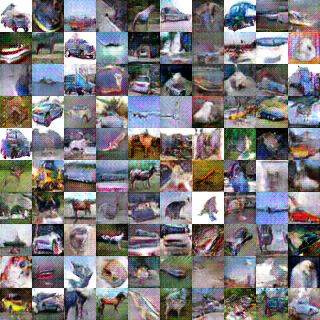

In [ ]:
display_png(Image(image_files[-1]))  # last snapshot

## Reference
[1] [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)